## Datos ICFES


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels
import sklearn.linear_model as lm
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.compat import lzip

#Datos eliminados. Archivo muy pesado. Se trabaja con el archivo limpiado data.csv
#data=pd.read_csv("C:/Users/marti/OneDrive/Documentos/personal/Universidad/Econometria/Saber_11.csv")


#Limpieza
#column_descartadas=data.columns[[0,1,3,4,5,6,8,9,10,11,12,13,16,19,20,22,24,25,26,27,28,33,37,38,41,43,44,45,46,47,48,51,52,53,55,56,57,58,59,61,62,64,65,67,68,70,71,73,74,76,77,78,79,80,81]]#Lista de nombres de columnas a descartar"ESTU_TIPODOCUMENTO","ESTU_NACIONALIDAD","ESTU_NACIONALIDAD","ESTU_"
#Combinar vab de calidad de vida. PCA categórico??
#data.drop(column_descartadas, inplace=True,axis=1) 
#data.info()
#print(data.describe(include=["O"]))#Descripción categóricas
#data.head()

In [ ]:
#Creacion variables
data=data[data.ESTU_GENERO != "-"]#eliminación filas sin género
data=data[(data.FAMI_ESTRATOVIVIENDA != "-" ) & (data.FAMI_ESTRATOVIVIENDA !="Sin Estrato")& ~( data.FAMI_ESTRATOVIVIENDA.isna())] #Eliminación filas sin especificación de estrato (& realiza elemento a elemento)
data=data[data.FAMI_PERSONASHOGAR != "-"]
data=data[(data.FAMI_EDUCACIONPADRE != "-")&(data.FAMI_EDUCACIONPADRE != "No Aplica")]
data=data[(data.FAMI_EDUCACIONMADRE != "-")&(data.FAMI_EDUCACIONMADRE != "No Aplica")]

data=data[(data.FAMI_TIENEINTERNET != "-")]
data=data[(data.FAMI_TIENECOMPUTADOR != "-")]


data=data[(data.FAMI_NUMLIBROS != "-")]
data=data[(data.ESTU_DEDICACIONLECTURADIARIA !="-")]
data=data[(data.ESTU_DEDICACIONINTERNET !="-")]

data=data[(data.FAMI_COMELECHEDERIVADOS != "-")]
data=data[(data.FAMI_COMECARNEPESCADOHUEVO != "-")]
data=data[(data.FAMI_COMECEREALFRUTOSLEGUMBRE != "-")]

data=data[(data.ESTU_HORASSEMANATRABAJA != "-")]


#Creación variables
data.ESTU_GENERO=pd.get_dummies(data.ESTU_GENERO).M #0 si es mujer, 1 si es hombre
data.ESTU_TIENEETNIA= (data.ESTU_TIENEETNIA=="Si").astype(int)
data.FAMI_ESTRATOVIVIENDA=data.FAMI_ESTRATOVIVIENDA.str.split(" ").str[1].astype(int) #Extraer solo el número del estrato

condiciones = [
    data['FAMI_PERSONASHOGAR'].eq('1 a 2'), data['FAMI_PERSONASHOGAR'].eq('3 a 4'),
    data['FAMI_PERSONASHOGAR'].eq('5 a 6'),data['FAMI_PERSONASHOGAR'].eq('7 a 8'),
    data['FAMI_PERSONASHOGAR'].eq('9 o más')
]
opciones = [1,3,5,7,9]
data.FAMI_PERSONASHOGAR = np.select(condiciones, opciones, default=0)
#data.FAMI_PERSONASHOGAR =(data.FAMI_PERSONASHOGAR >= 7).astype(int)

data.FAMI_EDUCACIONPADRE.value_counts()
condiciones = [
    data.FAMI_EDUCACIONPADRE.eq("Secundaria (Bachillerato) completa") |data.FAMI_EDUCACIONPADRE.eq('Educación profesional completa')
    |data.FAMI_EDUCACIONPADRE.eq("Técnica o tecnológica completa")|data.FAMI_EDUCACIONPADRE.eq("Técnica o tecnológica incompleta")
    |data.FAMI_EDUCACIONPADRE.eq("Educación profesional incompleta")| data.FAMI_EDUCACIONPADRE.eq("Postgrado")
]
opciones=[1]
data.FAMI_EDUCACIONPADRE=np.select(condiciones, opciones, default=0)
condiciones = [
    data.FAMI_EDUCACIONMADRE.eq("Secundaria (Bachillerato) completa") | data.FAMI_EDUCACIONMADRE.eq('Educación profesional completa')
    | data.FAMI_EDUCACIONMADRE.eq("Técnica o tecnológica completa")|data.FAMI_EDUCACIONMADRE.eq("Técnica o tecnológica incompleta")
    |data.FAMI_EDUCACIONMADRE.eq("Educación profesional incompleta")| data.FAMI_EDUCACIONMADRE.eq("Postgrado")
]
opciones=[1]
data.FAMI_EDUCACIONMADRE=np.select(condiciones, opciones, default=0)
#Conectividad
condiciones = [
    data.FAMI_TIENECOMPUTADOR.eq("Si") |data.FAMI_TIENEINTERNET.eq('Si')
]
data.FAMI_TIENECOMPUTADOR=np.select(condiciones, opciones, default=0)


data.drop("FAMI_TIENEINTERNET", inplace=True,axis=1)
data.rename(columns = {'FAMI_TIENECOMPUTADOR':'conectividad'}, inplace = True) #se puede cambiar: asignar a data["conectividad"] directamente
#Libros
condiciones = [
    data['FAMI_NUMLIBROS'].eq('0 A 10 LIBROS'), data['FAMI_NUMLIBROS'].eq('11 A 25 LIBROS'),
    data['FAMI_NUMLIBROS'].eq('26 A 100 LIBROS'),data['FAMI_NUMLIBROS'].eq('MÁS DE 100 LIBROS')
]
opciones = [10,25,50,100]
data.FAMI_NUMLIBROS=np.select(condiciones, opciones, default=0)
#Dedicación
condiciones = [
    data['ESTU_DEDICACIONLECTURADIARIA'].eq('No leo por entretenimiento'),
    data['ESTU_DEDICACIONLECTURADIARIA'].eq('30 minutos o menos'),
    data['ESTU_DEDICACIONLECTURADIARIA'].eq('Entre 30 y 60 minutos'),
    data['ESTU_DEDICACIONLECTURADIARIA'].eq('Entre 1 y 2 horas'),
    data['ESTU_DEDICACIONLECTURADIARIA'].eq('Más de 2 horas')
]
opciones = [0,3,6,12,18]
data.ESTU_DEDICACIONLECTURADIARIA=np.select(condiciones, opciones, default=0)

condiciones = [
    data['ESTU_DEDICACIONINTERNET'].eq('No Navega Internet'),
    data['ESTU_DEDICACIONINTERNET'].eq('30 minutos o menos'),
    data['ESTU_DEDICACIONINTERNET'].eq('Entre 30 y 60 minutos'),
    data['ESTU_DEDICACIONINTERNET'].eq('Entre 1 y 3 horas'),
    data['ESTU_DEDICACIONINTERNET'].eq('Más de 3 horas')
]
opciones = [0,3,6,12,18]
data.ESTU_DEDICACIONINTERNET=np.select(condiciones, opciones, default=0)

#Alimentación
condiciones = [
    data['FAMI_COMELECHEDERIVADOS'].eq('3 a 5 veces por semana')| data['FAMI_COMELECHEDERIVADOS'].eq('Todos o casi todos los días')
]
opciones = [1]
data.FAMI_COMELECHEDERIVADOS=np.select(condiciones, opciones, default=0)

condiciones = [
    data['FAMI_COMECARNEPESCADOHUEVO'].eq('3 a 5 veces por semana')| data['FAMI_COMECARNEPESCADOHUEVO'].eq('Todos o casi todos los días')
]
opciones = [1]
data.FAMI_COMECARNEPESCADOHUEVO=np.select(condiciones, opciones, default=0)

condiciones = [
    data['FAMI_COMECEREALFRUTOSLEGUMBRE'].eq('3 a 5 veces por semana')| data['FAMI_COMECEREALFRUTOSLEGUMBRE'].eq('Todos o casi todos los días')
]
opciones = [1]
data.FAMI_COMECEREALFRUTOSLEGUMBRE=np.select(condiciones, opciones, default=0)

data["alimentacion"]=data[['FAMI_COMELECHEDERIVADOS', 'FAMI_COMECARNEPESCADOHUEVO','FAMI_COMECEREALFRUTOSLEGUMBRE']].sum(axis=1)
data.alimentacion=(data.alimentacion>=2).astype(int)

data.drop(['FAMI_COMELECHEDERIVADOS','FAMI_COMECARNEPESCADOHUEVO','FAMI_COMECEREALFRUTOSLEGUMBRE'], inplace=True,axis=1)
#Trabaja
data.ESTU_HORASSEMANATRABAJA=(data.ESTU_HORASSEMANATRABAJA.eq('0')).astype(int)
#Oficiales/no oficiales
data.COLE_NATURALEZA=(data.COLE_NATURALEZA.eq("NO OFICIAL")).astype(int)
#Rural/urbano
data.COLE_AREA_UBICACION=(data.COLE_AREA_UBICACION.eq("URBANO")).astype(int)

#Agrupación por colegio
#'ESTU_DEDICACIONLECTURADIARIA','ESTU_DEDICACIONINTERNET','FAMI_NUMLIBROS' tienen relevancia para análisis individual
#data_colegios=data.groupby(['COLE_NOMBRE_ESTABLECIMIENTO','COLE_NATURALEZA','COLE_AREA_UBICACION','COLE_DEPTO_UBICACION'],as_index=False)[['ESTU_TIENEETNIA','FAMI_ESTRATOVIVIENDA','FAMI_PERSONASHOGAR','FAMI_EDUCACIONPADRE','FAMI_EDUCACIONMADRE','ESTU_DEDICACIONLECTURADIARIA','ESTU_DEDICACIONINTERNET','FAMI_NUMLIBROS','conectividad','alimentacion','ESTU_HORASSEMANATRABAJA','PUNT_GLOBAL']].mean()

#Columnas consideradas en la regresión
#data_reg=data_colegios[['COLE_NATURALEZA', 'COLE_AREA_UBICACION', 'ESTU_TIENEETNIA', 'FAMI_ESTRATOVIVIENDA','FAMI_PERSONASHOGAR','FAMI_EDUCACIONPADRE','FAMI_EDUCACIONMADRE','conectividad','alimentacion','ESTU_HORASSEMANATRABAJA','PUNT_GLOBAL']]

#Creación archivo
#data_colegios.to_csv(path_or_buf="C:/Users/marti/OneDrive/Documentos/personal/Universidad/Econometria/Proyecto/data_colegios.csv")


In [4]:
#Lectura de archivo creado 
datos=pd.read_csv("C:/Users/marti/OneDrive/Documentos/personal/Universidad/Econometria/Proyecto/Proyecto-Econometria-I/data_colegios.csv")
data_reg=datos[['COLE_NATURALEZA', 'COLE_AREA_UBICACION', 'ESTU_TIENEETNIA', 'FAMI_ESTRATOVIVIENDA','FAMI_PERSONASHOGAR','FAMI_EDUCACIONPADRE','FAMI_EDUCACIONMADRE','conectividad','alimentacion','ESTU_HORASSEMANATRABAJA','PUNT_GLOBAL']]

<AxesSubplot:xlabel='COLE_AREA_UBICACION', ylabel='PUNT_GLOBAL'>

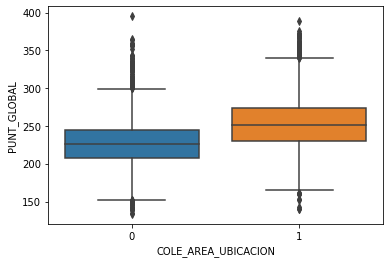

In [5]:
#sns.boxplot(x="COLE_AREA_UBICACION",y="PUNT_GLOBAL",data=data_reg)
#sns.boxplot(x="COLE_NATURALEZA",y="PUNT_GLOBAL",data=data_reg)#.iloc[:,1:])

#sns.heatmap(data_reg.corr(),cmap="Blues")
#data_reg.corr()
#data_colegios.info()




In [ ]:
cuanti=data_colegios[['COLE_AREA_UBICACION','FAMI_ESTRATOVIVIENDA','FAMI_PERSONASHOGAR','FAMI_EDUCACIONPADRE','FAMI_EDUCACIONMADRE','conectividad','alimentacion','PUNT_GLOBAL']]
plt.close()
sns.set_style("whitegrid")
sns.pairplot(cuanti,hue="COLE_AREA_UBICACION",height=3)
plt.show()

In [ ]:
data_reg.ESTU_TIENEETNIA=np.log(data_reg.ESTU_TIENEETNIA)
data_reg.loc[data_reg.ESTU_TIENEETNIA.eq(-np.inf)]
#data_reg.FAMI_PERSONASHOGAR=np.log(data_reg.FAMI_PERSONASHOGAR) Si ponemos como dummy
data_reg.FAMI_EDUCACIONPADRE=np.log(data_reg.FAMI_EDUCACIONPADRE)
data_reg.FAMI_EDUCACIONMADRE=np.log(data_reg.FAMI_EDUCACIONMADRE)
data_reg.conectividad=np.log(data_reg.conectividad)
data_reg.alimentacion=np.log(data_reg.alimentacion)



In [ ]:

X = sm.add_constant(data_reg[['COLE_NATURALEZA', 'COLE_AREA_UBICACION', 'ESTU_TIENEETNIA', 'FAMI_ESTRATOVIVIENDA','FAMI_PERSONASHOGAR','FAMI_EDUCACIONPADRE','FAMI_EDUCACIONMADRE','conectividad','alimentacion']])
reg = sm.OLS(data_reg["PUNT_GLOBAL"],X)
resultados=reg.fit()
print(resultados.summary())